# Testing the Convergence Hypothesis

### Double Lasso Method 

We use the double lasso approach when we have a high dimensional setting and we want to select variables to include in our regression. This will help us to avoid inflated Type I errors. The objective is to find covariates that can predict the independent and dependent variable. For example, we have this equation:
$$
  Y = \beta_1 D +  \beta_2'W + \epsilon.
  $$

$Y$ = rates of economic growth

$D$ = Initial wealth levels for each country

$W$ = controls for each country (country's institutional, educational, and other similar characteristics)

In this example we have 90 countries($n$) and 60 controls($p$), so the ratio $p/n$ is not small and we need to use the Double Lasso method. This consist in three steps:
- First, we run the regressions between the dependent variable  ($Y$) and the variable ($W$), where all the controls are. Also we run a regression between the independent variable $D$ and $W$. 
- From this two regressions we obtain the residuals for the first estimation ($\check{Y_i}$=$Y_i$-$\hat{\gamma}_{YW}$$W_i$) and second one($\check{D_i}$=$D_i$-$\hat{\gamma}_{DW}$$W_i$)
- Finally, the last step is to obtain the estimator $\check{\alpha}$ by using OLS method between $\check{Y_i}$, as the dependent variable, and $\check{D_i}$, as the independent one.

We will use different methods to testing the Convergence Hypothesis:
- OLS
- Double LASSO using cross Validation
- Double Lasso using theoretical Lambda
- Double Lasso using method="partialling out"

First, we will begin with the OLS, and we will see that the estimation by using this method will give us a noisy estimate with high standard error.

In [2]:
import hdmpy
import pandas as pd
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import random

## OLS

In [3]:
# I downloaded the data that the author used
growth_read = pyreadr.read_r("../data/GrowthData.RData")

# Extracting the data frame from rdata_read
growth = growth_read[ 'GrowthData' ]
list(growth)

['Outcome',
 'intercept',
 'gdpsh465',
 'bmp1l',
 'freeop',
 'freetar',
 'h65',
 'hm65',
 'hf65',
 'p65',
 'pm65',
 'pf65',
 's65',
 'sm65',
 'sf65',
 'fert65',
 'mort65',
 'lifee065',
 'gpop1',
 'fert1',
 'mort1',
 'invsh41',
 'geetot1',
 'geerec1',
 'gde1',
 'govwb1',
 'govsh41',
 'gvxdxe41',
 'high65',
 'highm65',
 'highf65',
 'highc65',
 'highcm65',
 'highcf65',
 'human65',
 'humanm65',
 'humanf65',
 'hyr65',
 'hyrm65',
 'hyrf65',
 'no65',
 'nom65',
 'nof65',
 'pinstab1',
 'pop65',
 'worker65',
 'pop1565',
 'pop6565',
 'sec65',
 'secm65',
 'secf65',
 'secc65',
 'seccm65',
 'seccf65',
 'syr65',
 'syrm65',
 'syrf65',
 'teapri65',
 'teasec65',
 'ex1',
 'im1',
 'xr65',
 'tot1']

In [4]:
growth.shape

(90, 63)

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [6]:
# We create the main variables
y = growth['Outcome']
X = growth.drop('Outcome', 1)

<ipython-input-6-8ba339c4a057>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = growth.drop('Outcome', 1)


In [7]:
# OLS regression
reg_ols  = sm.OLS(y, X).fit()
print(reg_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     3.607
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           0.000200
Time:                        15:07:02   Log-Likelihood:                 238.24
No. Observations:                  90   AIC:                            -352.5
Df Residuals:                      28   BIC:                            -197.5
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2472      0.785      0.315      0.7

In [8]:
# output: estimated regression coefficient corresponding to the target regressor
est_ols = reg_ols.summary2().tables[1]['Coef.']['gdpsh465']

# output: std. error
std_ols = reg_ols.summary2().tables[1]['Std.Err.']['gdpsh465']

# output: 95% confidence interval
lower_ci = reg_ols.summary2().tables[1]['[0.025']['gdpsh465']
upper_ci = reg_ols.summary2().tables[1]['0.975]']['gdpsh465']

In [10]:
table_1 = np.zeros( (1, 4) )

table_1[0,0] = est_ols  
table_1[0,1] = std_ols   
table_1[0,2] = lower_ci
table_1[0,3] = upper_ci    


table_1_pandas = pd.DataFrame( table_1, columns = [ "Estimator","Std. Error", "lower bound CI", "upper bound CI"  ])
table_1_pandas.index = [ "OLS" ]

table_1_pandas

,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.029888,-0.0706,0.051844


### Double LASSO using cross Validation (Sklearn)

In [11]:
# Create main variables
Y = growth['Outcome']
W = growth.drop(['Outcome','intercept', 'gdpsh465'], 1 )
D = growth['gdpsh465']

<ipython-input-11-fd57fb07bc70>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  W = growth.drop(['Outcome','intercept', 'gdpsh465'], 1 )


In [12]:
import random
import math

n=len(Y)
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(0)
random = np.random.randint(0,n, size=math.floor(n))
growth["random"] = random
random

array([44, 47, 64, 67, 67,  9, 83, 21, 36, 87, 70, 88, 88, 12, 58, 65, 39,
       87, 46, 88, 81, 37, 25, 77, 72,  9, 20, 80, 69, 79, 47, 64, 82, 88,
       49, 29, 19, 19, 14, 39, 32, 65,  9, 57, 32, 31, 74, 23, 35, 75, 55,
       28, 34,  0,  0, 36, 53,  5, 38, 17, 79,  4, 42, 58, 31,  1, 65, 41,
       57, 35, 11, 46, 82,  0, 14, 53, 12, 42, 84, 75, 68,  6, 68, 47,  3,
       76, 52, 78, 15, 20])

In [13]:
data_2 = growth.sort_values(by=['random'])
data_2.head()

,Outcome,intercept,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,...,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1,random
73,0.141445,1,7.511525,0.1053,0.228424,0.029328,0.103,0.139,0.054,1.00,...,1.700,2.369,1.060,51.7,37.1,0.0903,0.1229,484.00,0.007257,0
53,0.000408,1,7.880804,0.2927,0.248714,0.036270,0.177,0.172,0.140,1.00,...,0.724,0.758,0.690,29.1,22.6,0.1526,0.1976,8.57,-0.030185,0
54,-0.015680,1,7.301148,0.1621,0.299252,0.037367,0.078,0.104,0.054,0.75,...,0.405,0.430,0.381,53.3,18.0,0.1148,0.1244,2.50,-0.007018,0
65,0.066598,1,7.675082,0.0898,0.188016,0.045678,0.269,0.338,0.200,1.00,...,0.687,0.745,0.630,37.5,16.4,0.0906,0.0959,25.00,0.191066,1
84,0.031895,1,8.645586,0.0000,0.288440,0.005995,0.256,0.301,0.199,1.00,...,1.307,1.579,1.062,18.9,11.3,0.1296,0.1458,652.85,-0.046278,3


In [14]:
# Create training and testing sample 
train = data_2[ : math.floor(n*4/5)]    # training sample
test =  data_2[ math.floor(n*4/5) : ]   # testing sample
print(train.shape)
print(test.shape)

(72, 64)
(18, 64)


In [15]:
# Create main variables for training sample 
Y_t = train['Outcome']
W_t = train.drop(['Outcome','intercept', 'gdpsh465'], 1 )
D_t = train['gdpsh465']

<ipython-input-15-20ccf58b7e46>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  W_t = train.drop(['Outcome','intercept', 'gdpsh465'], 1 )


In [16]:
from sklearn import linear_model

# Seat values for Lasso
lasso_model = linear_model.Lasso( alpha = 0.00077 )
r_Y = Y_t - lasso_model.fit( W_t, Y_t ).predict( W_t )
r_Y = r_Y.rename('r_Y')

# Part. out d
r_D = D_t - lasso_model.fit( W_t, D_t).predict( W_t )
r_D = r_D.rename('r_D')

# ols 
partial_lasso_fit = sm.OLS(r_Y, r_D).fit()

est_lasso = partial_lasso_fit.summary2().tables[1]['Coef.']['r_D']
std_lasso = partial_lasso_fit.summary2().tables[1]['Std.Err.']['r_D']
lower_ci_lasso = partial_lasso_fit.summary2().tables[1]['[0.025']['r_D']
upper_ci_lasso = partial_lasso_fit.summary2().tables[1]['0.975]']['r_D']

C:\Users\hinte\anaconda3\envs\rtutorial\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010861597607676597, tolerance: 1.963131075242785e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\hinte\anaconda3\envs\rtutorial\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0389908452306296, tolerance: 0.005980622645375027
  model = cd_fast.enet_coordinate_descent(


In [17]:
# Regress residuales
partial_lasso_fit = sm.OLS(r_Y, r_D).fit()
partial_lasso_est = partial_lasso_fit.summary2().tables[1]['Coef.']['r_D']

print( f"Coefficient for D via partialling-out using lasso (train sample) is {partial_lasso_est}" )

Coefficient for D via partialling-out using lasso (train sample) is -0.037999479022644125


In [18]:
# Create main variables for test sample 
Y_s = test['Outcome']
W_s = test.drop(['Outcome','intercept', 'gdpsh465'], 1 )
D_s = test['gdpsh465']

<ipython-input-18-6b0ca34ca254>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  W_s = test.drop(['Outcome','intercept', 'gdpsh465'], 1 )


In [19]:
# output: estimated regression coefficient corresponding to the target regressor
est_lasso = partial_lasso_fit.summary2().tables[1]['Coef.']['r_D']

# output: std. error
std_lasso = partial_lasso_fit.summary2().tables[1]['Std.Err.']['r_D']

# output: 95% confidence interval
lower_ci_lasso = partial_lasso_fit.summary2().tables[1]['[0.025']['r_D']
upper_ci_lasso = partial_lasso_fit.summary2().tables[1]['0.975]']['r_D']

In [26]:
table_2 = np.zeros( (1, 4) )

table_2[0,0] = est_lasso  
table_2[0,1] = std_lasso   
table_2[0,2] = lower_ci_lasso
table_2[0,3] = upper_ci_lasso    


table_2_pandas = pd.DataFrame( table_2, columns = [ "Estimator","Std. Error", "lower bound CI", "upper bound CI"  ])
table_2_pandas.index = [ "LASSO (CV)" ]

table_3 = table_1_pandas.append(table_2_pandas)
table_3

,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.029888,-0.070600,0.051844
LASSO (CV),-0.037999,0.022736,-0.083333,0.007334


### Double Lasso using theoretical Lambda

In [21]:
res_Y_l = hdmpy.rlasso( W, Y, post=True ).est['residuals']
res_D_l = hdmpy.rlasso( W, D, post=True ).est['residuals']

r_Y_l = pd.DataFrame(res_Y_l, columns=['r_Y'])
r_D_l = pd.DataFrame(res_D_l, columns=['r_D'])

In [22]:
# OLS regression
reg_ols  = sm.OLS(r_Y_l, r_D_l).fit()
print(reg_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                    r_Y   R-squared (uncentered):                   0.127
Model:                            OLS   Adj. R-squared (uncentered):              0.117
Method:                 Least Squares   F-statistic:                              12.92
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                    0.000533
Time:                        15:09:58   Log-Likelihood:                          152.68
No. Observations:                  90   AIC:                                     -303.4
Df Residuals:                      89   BIC:                                     -300.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [23]:
# output: estimated regression coefficient corresponding to the target regressor
est_lasso_l = reg_ols.summary2().tables[1]['Coef.']['r_D']

# output: std. error
std_lasso_l = reg_ols.summary2().tables[1]['Std.Err.']['r_D']

# output: 95% confidence interval
lower_ci_lasso_l= reg_ols.summary2().tables[1]['[0.025']['r_D']
upper_ci_lasso_l = reg_ols.summary2().tables[1]['0.975]']['r_D']

In [25]:
table_4 = np.zeros( (1, 4) )

table_4[0,0] = est_lasso_l   
table_4[0,1] = std_lasso_l   
table_4[0,2] = lower_ci_lasso_l
table_4[0,3] = upper_ci_lasso_l    


table_4_pandas = pd.DataFrame( table_3, columns = [ "Estimator","Std. Error", "lower bound CI", "upper bound CI"  ]) 
table_4_pandas.index = [ "LASSO (hdmpy)" ]
table_4_pandas

,Estimator,Std. Error,lower bound CI,upper bound CI
LASSO (hdmpy),-0.049811,0.013858,-0.077347,-0.022276


In [27]:
table_5 = table_3.append(table_4_pandas)
table_5

,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.029888,-0.070600,0.051844
LASSO (CV),-0.037999,0.022736,-0.083333,0.007334
LASSO (hdmpy),-0.049811,0.013858,-0.077347,-0.022276


### Double Lasso using method="partialling out"

In [28]:
lasso_direct = hdmpy.rlassoEffect(x=W, y=Y, d=D, method="partialling out")
lasso_direct

{'alpha': -0.04981144483733839,
 'se': array([0.01539133]),
 't': array([-3.23633167]),
 'pval': array([0.00121077]),
 'coefficients': -0.04981144483733839,
 'coefficient': -0.04981144483733839,
 'coefficients_reg':                     0
 (Intercept)  0.058101
 x0          -0.075565
 x1           0.000000
 x2           0.000000
 x3           0.000000
 ...               ...
 x55          0.000000
 x56          0.000000
 x57          0.000000
 x58          0.000000
 x59          0.000000
 
 [61 rows x 1 columns],
 'selection_index': array([[ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
     

In [30]:
est_lasso_h = lasso_direct["coefficients"]
std_lasso_h = lasso_direct["se"]
lower_ci_lasso_h = est_lasso_h - 1.96*std_lasso_h
upper_ci_lasso_h = est_lasso_h + 1.96*std_lasso_h

In [31]:
est_lasso_h

-0.04981144483733839

In [32]:
std_lasso_h=list(std_lasso_h)

In [33]:
std_lasso_h=std_lasso_h[0]

In [34]:
std_lasso_h

0.015391328783055026

In [35]:
table_6 = np.zeros( (1, 4) )

table_6[0,0] = est_lasso_h   
table_6[0,1] = std_lasso_h  
table_6[0,2] = lower_ci_lasso_h 
table_6[0,3] = upper_ci_lasso_h     


table_6_pandas = pd.DataFrame( table_6, columns = [ "Estimator","Std. Error", "lower bound CI", "upper bound CI"  ]) 
table_6_pandas.index = [ "LASSO_direct" ]
table_6_pandas

,Estimator,Std. Error,lower bound CI,upper bound CI
LASSO_direct,-0.049811,0.015391,-0.079978,-0.019644


### Summary

In [37]:
table_7 = table_5.append(table_6_pandas)
table_7

,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.029888,-0.070600,0.051844
LASSO (CV),-0.037999,0.022736,-0.083333,0.007334
LASSO (hdmpy),-0.049811,0.013858,-0.077347,-0.022276
LASSO_direct,-0.049811,0.015391,-0.079978,-0.019644


In [38]:
data = pd.DataFrame({'variable':['OLS','LASSO(CV)','HDMPY', 'HDMPY_direct'], 'coefficient':[est_ols,est_lasso,est_lasso_l,est_lasso_h], 'std_error':[std_ols, std_lasso,std_lasso_l, std_lasso_h]})

In [39]:
data

,variable,coefficient,std_error
0,OLS,-0.009378,0.029888
1,LASSO(CV),-0.037999,0.022736
2,HDMPY,-0.049811,0.013858
3,HDMPY_direct,-0.049811,0.015391


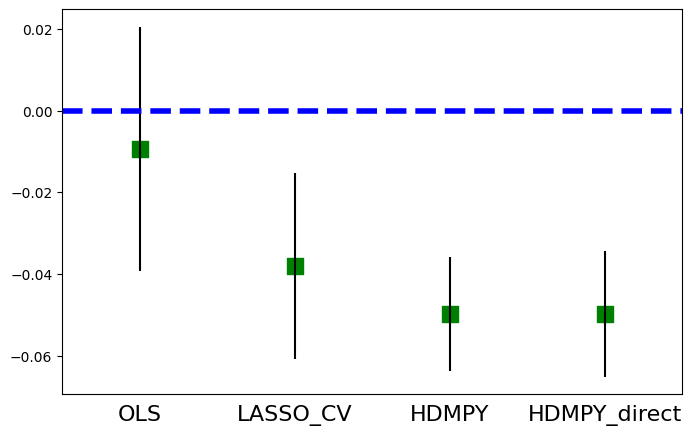

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))
data.plot(x='variable', y='coefficient', kind='bar', 
             ax=ax, color='none', 
             yerr='std_error', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=np.arange(data.shape[0]), 
           marker='s', s=120, 
           y=data['coefficient'], color='green')
ax.axhline(y=0, linestyle='--', color='blue', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['OLS','LASSO_CV','HDMPY','HDMPY_direct'], 
                       rotation=0, fontsize=16)

plt.show()

### Following the results of the graphic above, we can say that double lasso methods give us a more precised estimation. Especially, when we use hte method with the theoretical lambda (HDMPY). The method allow us to obtain a high quality estimation of $\beta_1$. 